## EDA

In [1]:
# Import Libraries
#초기 설정및 시스템 라이브러리
import platform
import warnings

# 데이터 시각화 라이브러리
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
print(platform.system())
warnings.filterwarnings('ignore')

# 행,열,결과값 생략 없이 보기,세팅
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

# 시각화 OS별 한글폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 폰트 설정
elif platform.system() == 'Mac':
    plt.rcParams['font.family'] = 'AppleGothic'  # Mac 폰트 설정
    
print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

Windows
라이브러리 로드 완료!
한글 폰트 설정 완료!


### 성장률

In [2]:
# Load Dataset (join)
df_growth_industry = pd.read_csv("./data/join/growth_industry_final.csv")    # 성장률(산업)
df_growth_size     = pd.read_csv("./data/join/growth_size_final.csv")        # 성장률(규모)
df_growth_addr     = pd.read_csv("./data/join/growth_addr_final.csv")        # 성장률(위치)
df_growth_issues   = pd.read_csv("./data/join/growth_issues_final.csv")      # 성장률(이슈/마일스톤)

#### 성장률(산업)
(obj, fr)
어떤 산업군에 속한 스타트업의 투자라운드 성장률이 높을까

In [3]:
# 분석 단위 (회사당 여러 라운드)
# df_growth_industry
print(df_growth_industry.shape) # (483539, 62)
print(df_growth_industry[["objects_cfpr_id"]].nunique()) # ignore NaN values 462620
display(round((df_growth_industry["funding_round_id"].notna().mean()*100),2)) #10.88%

(483539, 62)
objects_cfpr_id    462620
dtype: int64


np.float64(10.88)

In [4]:
# 스타트업 관점이므로 object_cfpr_id를 'c'로 제한
print(df_growth_industry.shape[0]) # 조건 부여 전 483539행
cond1 = (df_growth_industry['objects_cfpr_id'].str[0] == "c")
growth_industry = df_growth_industry.loc[cond1]
print(growth_industry.shape[0]) # 조건 부여 후 217468행

483539
217468


투자라운드 없느 회사가 얼마나 될까?

In [5]:
# 투자 라운드가 없는 회사? → 164842건
cond1 = (growth_industry["funding_round_id"].isna())
num_no_fr = growth_industry.loc[cond1, "objects_cfpr_id"].nunique()

# 전체에서 비율 → 83.87%???
total_company = growth_industry["objects_cfpr_id"].nunique()
no_fr_ratio = round(num_no_fr/total_company * 100, 2)

print("전체 회사 수:", total_company)
print("투자 라운드가 없는 회사 수:", num_no_fr)
print("비율:", no_fr_ratio,"%")

전체 회사 수: 196549
투자 라운드가 없는 회사 수: 164842
비율: 83.87 %


count    196549.000000
mean          0.267750
std           0.778235
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: funding_round_id, dtype: float64


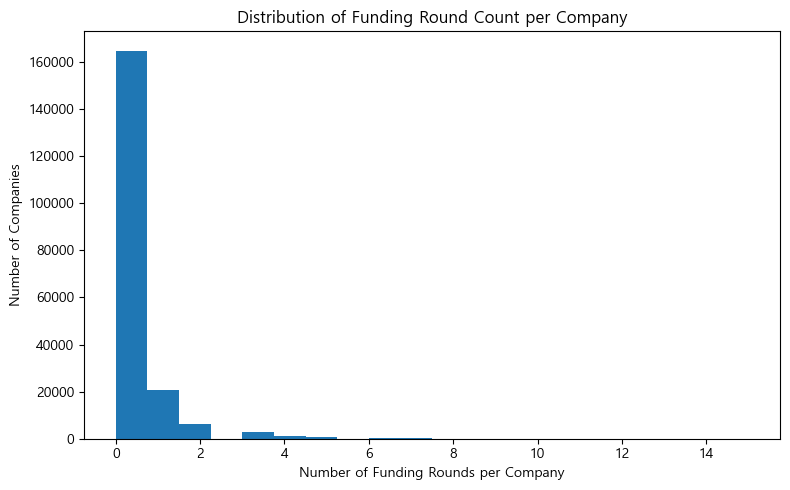

In [6]:
# 라운드 분포 시각화
# 회사별 투자 라운드 수 (NaN은 투자 없음이므로 제외하고 count)
fr_count_by_company = (
    growth_industry.groupby("objects_cfpr_id")["funding_round_id"]
    .apply(lambda x: x.notna().sum())
)

print(fr_count_by_company.describe())

# 3) 분포 시각화 (히스토그램)
plt.figure(figsize=(8, 5))
plt.hist(fr_count_by_company, bins=20)
plt.title("Distribution of Funding Round Count per Company")
plt.xlabel("Number of Funding Rounds per Company")
plt.ylabel("Number of Companies")
plt.tight_layout()
plt.show()

TOP5 산업군은 무엇일까?

In [7]:
# 산업군 분포확인
display(growth_industry["category_code"].describe())
display(growth_industry["category_code"].value_counts(dropna=False).head(10))

count       143886
unique          42
top       software
freq         20759
Name: category_code, dtype: object

category_code
NaN            73582
software       20759
web            16553
other          13840
ecommerce       9955
mobile          8400
games_video     8289
advertising     7200
biotech         7181
enterprise      6055
Name: count, dtype: int64

산업군의 이상치는?

In [8]:
# category_code 이상치 분석
# 1) category_code가 없는 건 일단 제외
cond1 = growth_industry["category_code"].notna()
growth_industry = growth_industry[cond1]

# 2) (category_code, 회사) 쌍 기준으로 중복 제거 → 한 회사가 같은 category_code로 여러 행 있어도 1번만 카운트
growth_industry_unique = growth_industry.drop_duplicates(subset=["category_code", "objects_cfpr_id"])

# 3) category_code별 회사 수 (고유 회사 기준)
cat_company_counts = (
    growth_industry_unique
    .groupby("category_code")["objects_cfpr_id"]
    .nunique()
    .rename("cat_company_cnt")
    .sort_values(ascending=False)
)

print(cat_company_counts.sum())
display(cat_company_counts)


123186


category_code
software            17922
web                 15118
other               13617
ecommerce            9065
games_video          7520
mobile               6862
advertising          6098
consulting           5006
enterprise           4441
biotech              4430
hardware             2951
education            2901
public_relations     2846
network_hosting      2350
search               2182
cleantech            1940
health               1698
finance              1386
social               1310
security             1171
medical              1153
analytics            1022
legal                1012
travel                936
local                 785
news                  768
hospitality           768
semiconductor         696
manufacturing         680
sports                675
music                 581
fashion               563
photo_video           544
transportation        489
real_estate           474
messaging             296
automotive            291
design                28

In [9]:
# IQR로 이상치 파악
Q1 = cat_company_counts.quantile(0.25)  # 1사분위수
Q3 = cat_company_counts.quantile(0.75)  # 3사분위수
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("lower_bound:", lower_bound)
print("upper_bound:", upper_bound)

Q1: 567.5
Q3: 2938.5
IQR: 2371.0
lower_bound: -2989.0
upper_bound: 6495.0


In [10]:
# 1) 상한 초과 → 회사 수가 유난히 많은 카테고리
high_outliers = cat_company_counts[cat_company_counts > upper_bound]

# 2) 하한 미만 → 회사 수가 유난히 적은 카테고리
low_outliers = cat_company_counts[cat_company_counts < lower_bound]

print("❓ 회사 수가 많은 이상치 카테고리")
print(high_outliers)

print("\n❓ 회사 수가 적은 이상치 카테고리")
print(low_outliers)

❓ 회사 수가 많은 이상치 카테고리
category_code
software       17922
web            15118
other          13617
ecommerce       9065
games_video     7520
mobile          6862
Name: cat_company_cnt, dtype: int64

❓ 회사 수가 적은 이상치 카테고리
Series([], Name: cat_company_cnt, dtype: int64)


산업군별 투자라운드 성장률은?

In [11]:
# 회사별 라운드 수, 처음/마지막 라운드 금액
growth_industry_rounds = growth_industry[growth_industry["funding_round_id"].notna()].copy() # 투자라운드 NOTNULL값들만
growth_industry_company = (
    growth_industry_rounds
    .sort_values(["objects_cfpr_id", "funded_year"])  # 시간 순 정렬
    .groupby("objects_cfpr_id")
    .agg(
        category_code   =("category_code", "first"),        # 첫번째 카테고리값
        n_rounds        =("funding_round_id", "count"),     # funding_rounds id 갯수
        first_round_amt =("raised_amount_usd", "first"),    # 첫번째 조달금액
        last_round_amt  =("raised_amount_usd", "last"),     # 마지막 조달금액
        first_year      =("funded_year", "first"),          # 첫번째 투자년도
        last_year       =("funded_year", "last")            # 마지막 투자년도
    )
)

# 성장률(단순 비율) 마지막 조달금액/첫번째 조달금액
last_amt    = growth_industry_company["last_round_amt"]
first_amt   = growth_industry_company["first_round_amt"]
#growth_industry_company["growth_ratio"] = ((last_amt - first_amt) / last_amt * 100)
growth_industry_company["growth_ratio"] = last_amt / first_amt
# 0으로 나눈 케이스 제거
growth_industry_company = growth_industry_company[first_amt > 0]

growth_industry_company

,category_code,n_rounds,first_round_amt,last_round_amt,first_year,last_year,growth_ratio
objects_cfpr_id,,,,,,,
c:1,web,3,5250000.0,25000000.0,2005.0,2008.0,4.761905
c:1001,web,1,5000000.0,5000000.0,2008.0,2008.0,1.000000
c:10015,health,5,2000000.0,43000000.0,2008.0,2013.0,21.500000
c:100155,cleantech,3,6500000.0,3250000.0,2011.0,2012.0,0.500000
c:10018,analytics,3,8000000.0,15000000.0,2008.0,2013.0,1.875000
...,...,...,...,...,...,...,...
c:99853,social,1,500000.0,500000.0,2011.0,2011.0,1.000000
c:9989,games_video,2,600000.0,500000.0,2008.0,2009.0,0.833333
c:9994,advertising,2,250000.0,250000.0,2007.0,2008.0,1.000000


In [12]:
# 산업군별 투자라운드 성장률 비교
growth_by_category = (
    growth_industry_company
    .groupby("category_code") # 산업군별
    .agg(
        mean_growth     = ("growth_ratio", "mean"),
        median_growth   = ("growth_ratio", "median"),
        n_firms         = ("growth_ratio", "count"),
        avg_rounds      = ("n_rounds", "mean")
    )
    .sort_values(
        by=["mean_growth", "avg_rounds"],
        ascending=[False, False]   # 둘 다 내림차순
    )
)
display(growth_by_category)
display(growth_by_category["n_firms"].describe())

,mean_growth,median_growth,n_firms,avg_rounds
category_code,,,,
transportation,21.667572,1.0,77,1.909091
real_estate,17.895522,1.0,128,1.523438
travel,9.609270,1.0,197,1.649746
social,9.368582,1.0,538,1.669145
news,8.355668,1.0,188,1.776596
security,8.322474,1.0,371,1.900270
music,6.822007,1.0,165,1.848485
automotive,6.312888,1.0,74,2.013514
enterprise,5.549152,1.0,1436,2.102368


count      42.000000
mean      639.452381
std       868.037546
min         9.000000
25%       129.250000
50%       341.500000
75%       649.500000
max      4226.000000
Name: n_firms, dtype: float64

산업군별 표본수에 기준을 주어야 할까?

In [13]:
# 표본 수 기준을 median으로 잡아볼까?
display(growth_by_category["n_firms"].describe())

median_n_firms = growth_by_category["n_firms"].median()
growth_by_cat_filtered = growth_by_category[
    growth_by_category["n_firms"] >= median_n_firms
].copy()

growth_by_category_sorted = growth_by_cat_filtered.sort_values(
    by=["mean_growth", "avg_rounds"],
    ascending=[False, False]
)
display(growth_by_category_sorted)

count      42.000000
mean      639.452381
std       868.037546
min         9.000000
25%       129.250000
50%       341.500000
75%       649.500000
max      4226.000000
Name: n_firms, dtype: float64

,mean_growth,median_growth,n_firms,avg_rounds
category_code,,,,
social,9.368582,1.0,538,1.669145
security,8.322474,1.0,371,1.900270
enterprise,5.549152,1.0,1436,2.102368
finance,4.567009,1.0,461,1.789588
biotech,4.497819,1.0,3103,1.884950
ecommerce,4.135355,1.0,1334,1.640180
analytics,3.670430,1.0,621,2.086957
web,3.304696,1.0,2358,1.589483
education,3.256024,1.0,467,1.601713


#### 성장률(규모)
(obj, rel, fr)
어떤 규모의 스타트업 투자라운드 성장률이 높을까

In [14]:
# 분석 단위 (회사당 여러 라운드)
# df_growth_size
print(df_growth_size.shape) # (909183, 72)
print(df_growth_size[["objects_cfpr_id"]].nunique()) # ignore NaN values 462620
display(round((df_growth_size["rel_cf_id"].notna().mean()) * 100, 2)) # 63.92% notna
display(round((df_growth_size["funding_round_id"].notna().mean()) * 100, 2)) # 35.2% notna

(909183, 72)
objects_cfpr_id    462620
dtype: int64


np.float64(63.92)

np.float64(35.2)

In [15]:
# 스타트업 관점이므로 object_cfpr_id를 'c'로 제한
print(df_growth_size.shape[0]) # 조건 부여 전 909183행

growth_size = df_growth_size.copy()
cond1 = (growth_size['objects_cfpr_id'].str[0] == "c")
growth_size = growth_size.loc[cond1]

print(growth_size.shape[0]) # 조건 부여 후 614636행

909183
614636


스타트업(obj)이 관계(rel)에 의해 얼마나 증가할까?(행증가)

In [16]:
display(growth_size.head())
print(growth_size[["objects_cfpr_id"]].nunique()) # 196549
print(growth_size[["relationship_id"]].nunique()) # 364820
print(growth_size[["funding_round_id"]].nunique()) # 52626

,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,...,rel_cf_id,start_at,end_at,is_past,sequence,title,has_end_date,cat_rel_title,funding_round_id,fr_c_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private
0,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,...,c:1,NaN,NaN,0.0,8.0,Co-Founder/CEO/Board of Directors,0.0,Founder,888.0,c:1,2005-10-01,series-a,a,5250000.0,NaN,NaN,2.0,0.0,1.0,2005.0,2005Q4,series-a,1.0,1.098612,0.0
1,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,...,c:1,NaN,NaN,0.0,8.0,Co-Founder/CEO/Board of Directors,0.0,Founder,889.0,c:1,2007-01-01,series-b,b,9500000.0,NaN,NaN,3.0,0.0,0.0,2007.0,2007Q1,series-b,2.0,1.386294,0.0
2,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,200

objects_cfpr_id    196549
dtype: int64
relationship_id    364820
dtype: int64
funding_round_id    52626
dtype: int64


In [17]:
obj_n = growth_size["objects_cfpr_id"].nunique()
rel_n = growth_size["relationship_id"].nunique()

obj_rel_ratio = round((obj_n / rel_n) * 100, 2)

print(obj_rel_ratio) # 53.88% 증가!

53.88


In [18]:
# 관계 없거나 라운드 없는 회사
print(growth_size[["relationship_id"]].isna().sum()) # 68768
print(growth_size[["funding_round_id"]].isna().sum()) # 294638

cond1 = (growth_size["relationship_id"].isna())
cond2 = (growth_size["funding_round_id"].isna())

print("\n",growth_size.loc[cond1 | cond2, "funding_round_id"].sum()) # 235462187
print(growth_size.loc[cond1 | cond2, "funding_round_id"].value_counts().sum()) #8159
print(growth_size.loc[cond1 & cond2, "funding_round_id"].value_counts().sum()) # 0

relationship_id    68768
dtype: int64
funding_round_id    294638
dtype: int64

 235462187.0
8159
0


평균 스타트업당 몇 개의 관계가 있을까?

In [19]:
# 회사-사람 관계만으로 규모 요약
rel_per_company = (
    growth_size.dropna(subset=["rel_p_id"])  # 사람 관계 있는 행만
      .groupby("objects_cfpr_id")["rel_p_id"]
      .nunique()
      .rename("total_rel_count")
)

# 현재 관계만
current_rel_per_company = (
    growth_size[growth_size["is_past"] == 0]
      .groupby("objects_cfpr_id")["rel_p_id"]
      .nunique()
      .rename("current_rel_count")
)

# 전체&현재 관계 
growth_size_rel = (
    pd.concat([rel_per_company, current_rel_per_company], axis=1)
      .fillna(0)
)

display(growth_size_rel)

,total_rel_count,current_rel_count
objects_cfpr_id,,
c:1,15,8.0
c:10,6,0.0
c:100,12,4.0
c:10002,2,2.0
c:100042,1,1.0
...,...,...
c:99940,5,4.0
c:9995,14,4.0
c:9996,43,2.0


In [20]:
display(growth_size_rel["total_rel_count"].describe())
display(growth_size_rel["current_rel_count"].describe())

count    129341.00000
mean          2.76637
std           8.52377
min           1.00000
25%           1.00000
50%           1.00000
75%           3.00000
max        1091.00000
Name: total_rel_count, dtype: float64

count    129341.000000
mean          1.652732
std           2.951631
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         314.000000
Name: current_rel_count, dtype: float64

current_rel_count와 total_rel_count간 차이가 큰 회사?

In [21]:
# 전체에서 현재 관계 수가 얼마나 바뀌었나
growth_size_rel["diff_tot_cur_rel"] = (
    growth_size_rel["total_rel_count"] - growth_size_rel["current_rel_count"]
)

growth_size_rel_sorted = growth_size_rel.sort_values(
    by="diff_tot_cur_rel",
    ascending=False
)

display(growth_size_rel_sorted)
display(growth_size_rel_sorted.describe())

,total_rel_count,current_rel_count,diff_tot_cur_rel
objects_cfpr_id,,,
c:1242,1091,178.0,913.0
c:29,872,101.0,771.0
c:3246,818,87.0,731.0
c:59,987,314.0,673.0
c:4715,645,103.0,542.0
...,...,...,...
c:236239,3,3.0,0.0
c:236232,1,1.0,0.0
c:236226,3,3.0,0.0


,total_rel_count,current_rel_count,diff_tot_cur_rel
count,129341.00000,129341.000000,129341.000000
mean,2.76637,1.652732,1.113638
std,8.52377,2.951631,6.743113
min,1.00000,0.000000,0.000000
25%,1.00000,0.000000,0.000000
50%,1.00000,1.000000,0.000000
75%,3.00000,2.000000,1.000000
max,1091.00000,314.000000,913.000000


스타트업의 규모 분포

In [22]:
# 회사-사람 관계 규모 요약(growth_size_rel)까지는 이미 완성 상태라고 가정
growth_size_rel = growth_size_rel.reset_index()

# current_rel_count 규모 구간 만들기 : quantile 기반
q = growth_size_rel["current_rel_count"].quantile([0.25, 0.5, 0.75])

bins = [-1, q[0.25], q[0.5], q[0.75], growth_size_rel["current_rel_count"].max()]
labels = ["초소형팀", "소형팀", "중형팀", "대형팀"]

growth_size_rel["size_bin"] = pd.cut(growth_size_rel["current_rel_count"], bins=bins, labels=labels)
display(growth_size_rel["size_bin"].value_counts())

size_bin
소형팀     44881
초소형팀    42090
대형팀     24403
중형팀     17967
Name: count, dtype: int64

In [23]:
# 1) 회사-사람 관계 규모 요약(growth_size_rel)까지는 이미 완성 상태라고 가정
growth_size_rel = growth_size_rel.reset_index()

# 2) 회사 × 라운드 타입(cat_fr_type)
company_fr_type = (
    growth_size
    .dropna(subset=["cat_fr_type"])
    .groupby(["objects_cfpr_id", "cat_fr_type"])
    .size()
    .reset_index(name="n_rounds_type")
)

# 3) 회사 규모와 merge
growth_size_type = company_fr_type.merge(
    growth_size_rel,
    on="objects_cfpr_id",
    how="left"
)

In [24]:
# IQR 요약 함수 정의
def iqr_summary(df, col):
    q1 = df[col].quantile(0.25)
    q2 = df[col].quantile(0.50)  # median
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outlier_cnt = ((df[col] < lower) | (df[col] > upper)).sum()
    total_cnt   = df[col].shape[0]
    
    return pd.Series({
        "count": total_cnt,
        "q1": q1,
        "median": q2,
        "q3": q3,
        "iqr": iqr,
        "lower_bound": lower,
        "upper_bound": upper,
        "outlier_count": outlier_cnt,
        "outlier_ratio": outlier_cnt / total_cnt if total_cnt > 0 else np.nan
    })

In [25]:
# IQR 투자 라운드 별 규모(현재 관계 수 기준)
iqr_current_by_type = (
    growth_size_type
    .groupby("cat_fr_type")
    .apply(iqr_summary, col="current_rel_count")
    .sort_index()
)
display(iqr_current_by_type)

# IQR 투자 라운드 별 규모(전체 관계 수 기준)
iqr_total_by_type = (
    growth_size_type
    .groupby("cat_fr_type")
    .apply(iqr_summary, col="total_rel_count")
    .sort_index()
)

display(iqr_total_by_type)

,count,q1,median,q3,iqr,lower_bound,upper_bound,outlier_count,outlier_ratio
cat_fr_type,,,,,,,,,
debt_round,2738.0,2.0,3.0,5.00,3.00,-2.500,9.500,282.0,0.102995
grant,638.0,1.0,3.0,4.00,3.00,-3.500,8.500,54.0,0.084639
post-ipo,71.0,2.0,3.0,7.25,5.25,-5.875,15.125,5.0,0.070423
private-equity,994.0,2.0,3.0,7.00,5.00,-5.500,14.500,62.0,0.062374
secondary_market,14.0,15.0,19.0,21.00,6.00,6.000,30.000,2.0,0.142857
seed,10963.0,1.0,2.0,4.00,3.00,-3.500,8.500,433.0,0.039496
series-a,8845.0,2.0,3.0,6.00,4.00,-4.000,12.000,514.0,0.058112
series-b,4513.0,2.0,5.0,9.00,7.00,-8.500,19.500,106.0,0.023488
series-c+,2896.0,2.0,5.0,11.00,9.00,-11.500,24.500,38.0,0.013122


,count,q1,median,q3,iqr,lower_bound,upper_bound,outlier_count,outlier_ratio
cat_fr_type,,,,,,,,,
debt_round,2738.0,2.0,3.0,7.00,5.00,-5.500,14.500,199.0,0.072681
grant,638.0,2.0,3.0,5.25,3.25,-2.875,10.125,62.0,0.097179
post-ipo,71.0,3.0,5.0,10.00,7.00,-7.500,20.500,9.0,0.126761
private-equity,994.0,2.0,4.0,9.00,7.00,-8.500,19.500,54.0,0.054326
secondary_market,14.0,22.0,33.0,37.00,15.00,-0.500,59.500,1.0,0.071429
seed,10963.0,2.0,3.0,5.00,3.00,-2.500,9.500,637.0,0.058105
series-a,8845.0,2.0,5.0,9.00,7.00,-8.500,19.500,416.0,0.047032
series-b,4513.0,3.0,7.0,13.00,10.00,-12.000,28.000,125.0,0.027698
series-c+,2896.0,4.0,9.0,15.00,11.00,-12.500,31.500,81.0,0.027970


In [26]:
# 1) IQR 요약에서 필요한 컬럼만 추출
iqr_stats = iqr_current_by_type[[
    "q1", "median", "q3", "lower_bound", "upper_bound"
]].copy()

# 2) cat_fr_type 기준으로 IQR 값 join
growth_size_type_iqr = growth_size_type.merge(
    iqr_stats,
    left_on="cat_fr_type",
    right_index=True,
    how="left"
)

# 3) 타입별 IQR 기준으로 규모 구간 라벨링 함수
def label_size_by_type(row):
    val = row["current_rel_count"]
    q1 = row["q1"]
    q2 = row["median"]
    q3 = row["q3"]
    upper = row["upper_bound"]
    
    if pd.isna(val) or pd.isna(q1):
        return np.nan
    
    if val <= q1:
        return "투자라운드_초소형(Q1이하)"
    elif val <= q2:
        return "투자라운드_소형(Q1~Q2)"
    elif val <= q3:
        return "투자라운드_중형(Q2~Q3)"
    elif val <= upper:
        return "투자라운드_대형(Q3~Upper)"
    else:
        return "투자라운드_초대형(Upper초과)"

growth_size_type_iqr["size_bin_iqr_by_type"] = growth_size_type_iqr.apply(
    label_size_by_type,
    axis=1
)

display( growth_size_type_iqr["size_bin_iqr_by_type"].value_counts())

size_bin_iqr_by_type
투자라운드_초소형(Q1이하)       11511
투자라운드_소형(Q1~Q2)        8564
투자라운드_중형(Q2~Q3)        8122
투자라운드_대형(Q3~Upper)     5781
투자라운드_초대형(Upper초과)     2116
Name: count, dtype: int64

In [27]:
type_size_by_type = (
    growth_size_type_iqr
    .groupby(["cat_fr_type", "size_bin_iqr_by_type"])["objects_cfpr_id"]
    .nunique()
    .unstack(fill_value=0)
)

display(type_size_by_type)

size_bin_iqr_by_type,투자라운드_대형(Q3~Upper),투자라운드_소형(Q1~Q2),투자라운드_중형(Q2~Q3),투자라운드_초대형(Upper초과),투자라운드_초소형(Q1이하)
cat_fr_type,,,,,
debt_round,293,398,356,282,1073
grant,70,221,51,54,144
post-ipo,11,17,14,5,17
private-equity,124,120,196,62,331
secondary_market,1,4,3,1,4
seed,1315,2335,2800,433,2544
series-a,1372,1042,1924,514,2774
series-b,805,983,853,106,1236
series-c+,528,553,733,38,789


In [28]:
# growth_size에 붙일 컬럼만 슬림하게 준비
type_size_label = growth_size_type_iqr[[
    "objects_cfpr_id",
    "cat_fr_type",
    "size_bin_iqr_by_type"
]].drop_duplicates()

# 회사 단위 규모 정보 merge
growth_size_tmp = growth_size.merge(
    growth_size_rel,          # total_rel_count, current_rel_count, diff_tot_cur_rel
    on="objects_cfpr_id",
    how="left"
)

# 회사×라운드타입 규모구간 라벨 merge
growth_size_master = growth_size_tmp.merge(
    type_size_label,                # size_bin_iqr_by_type
    on=["objects_cfpr_id", "cat_fr_type"],
    how="left"
)

display(growth_size_master.head())

,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,...,has_end_date,cat_rel_title,funding_round_id,fr_c_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private,index,total_rel_count,current_rel_count,diff_tot_cur_rel,size_bin,size_bin_iqr_by_type
0,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,...,0.0,Founder,888.0,c:1,2005-10-01,series-a,a,5250000.0,NaN,NaN,2.0,0.0,1.0,2005.0,2005Q4,series-a,1.0,1.098612,0.0,0.0,15.0,8.0,7.0,대형팀,투자라운드_대형(Q3~Upper)
1,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3.0,39750000.0,2010-09-05,2013-09-18,...,0.0,Founder,889.0,c:1,2007-01-01,series-b,b,9500000.0,NaN,NaN,3.0,0.0,0.0,2007.0,2007Q1,series-b,2.0,1.386294,0.0,0.0,15.0,8.0,7.0,대형팀,투자라운드_중형(Q2~Q3)
2,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10

In [29]:
# 원본 growth_size에 merge
growth_size_with_bin = growth_size.merge(
    type_size_label,
    on=["objects_cfpr_id", "cat_fr_type"],
    how="left"
)

# 결과 확인
display(
    growth_size_with_bin[[
        "objects_cfpr_id",
        "cat_fr_type",
        "rel_p_id",
        "size_bin_iqr_by_type"
    ]].head(10)
)

# 전체 분포 한 번 체크
display(growth_size_with_bin["size_bin_iqr_by_type"].value_counts())

,objects_cfpr_id,cat_fr_type,rel_p_id,size_bin_iqr_by_type
0,c:1,series-a,p:2,투자라운드_대형(Q3~Upper)
1,c:1,series-b,p:2,투자라운드_중형(Q2~Q3)
2,c:1,series-c+,p:2,투자라운드_중형(Q2~Q3)
3,c:1,series-a,p:3,투자라운드_대형(Q3~Upper)
4,c:1,series-b,p:3,투자라운드_중형(Q2~Q3)
5,c:1,series-c+,p:3,투자라운드_중형(Q2~Q3)
6,c:1,series-a,p:7235,투자라운드_대형(Q3~Upper)
7,c:1,series-b,p:7235,투자라운드_중형(Q2~Q3)
8,c:1,series-c+,p:7235,투자라운드_중형(Q2~Q3)
9,c:1,series-a,p:10130,투자라운드_대형(Q3~Upper)


size_bin_iqr_by_type
투자라운드_대형(Q3~Upper)    97846
투자라운드_초대형(Upper초과)    76727
투자라운드_중형(Q2~Q3)       67797
투자라운드_소형(Q1~Q2)       39581
투자라운드_초소형(Q1이하)       29888
Name: count, dtype: int64

 회사 규모별 라운드 성장률은 어떻게 될까?

In [30]:
growth_size["funded_at"] = pd.to_datetime(growth_size["funded_at"], errors="coerce")

# 회사별 투자 라운드
growth_size_rounds_company = (
    growth_size.dropna(subset=["funding_round_id", "raised_amount_usd"])
      .sort_values(["objects_cfpr_id", "funded_at"])
      .groupby("objects_cfpr_id")
      .agg( # objects 기준 요약값
          n_rounds=("funding_round_id", "nunique"),
          first_round_amt=("raised_amount_usd", "first"),   # 첫번째 조달금액
          last_round_amt=("raised_amount_usd", "last"),     # 마지막 조달금액
          first_year=("funded_at", lambda x: x.min().year if x.notna().any() else np.nan),
          last_year=("funded_at", lambda x: x.max().year if x.notna().any() else np.nan),
          funding_total_usd=("funding_total_usd", "max") 
      )
)

# 성장률 계산 = 마지막 조달금액 / 첫번째 조달금액 (첫번째 조달금액이 0이상인 데이터만) 
last_amt    = growth_size_rounds_company["last_round_amt"]
first_amt   = growth_size_rounds_company["first_round_amt"]
growth_size_rounds_company = growth_size_rounds_company[first_amt > 0]
growth_size_rounds_company["growth_ratio"] = last_amt / first_amt

display(growth_size_rounds_company)

,n_rounds,first_round_amt,last_round_amt,first_year,last_year,funding_total_usd,growth_ratio
objects_cfpr_id,,,,,,,
c:1,3,5250000.0,25000000.0,2005.0,2005.0,39750000.0,4.761905
c:1001,1,5000000.0,5000000.0,NaN,NaN,5000000.0,1.000000
c:10015,5,2000000.0,2069200.0,2008.0,2008.0,68069200.0,1.034600
c:100155,3,6500000.0,375293.0,NaN,NaN,10125293.0,0.057737
c:10018,3,8000000.0,15000000.0,NaN,NaN,33000000.0,1.875000
...,...,...,...,...,...,...,...
c:99853,1,500000.0,500000.0,NaN,NaN,500000.0,1.000000
c:9989,2,600000.0,500000.0,NaN,NaN,1100000.0,0.833333
c:9994,2,250000.0,250000.0,NaN,NaN,500000.0,1.000000


#### 성장률(위치)
(off, obj, fr)

In [31]:
print(df_growth_addr.shape)     # (139191, 73)
display(df_growth_addr.head()) 

print(df_growth_addr[["office_id"]].nunique())          # 112718
print(df_growth_addr[["objects_cfpr_id"]].nunique())    # 95043
print(df_growth_addr[["funding_round_id"]].nunique())   # 50182

(139191, 73)


,offices_c_id,office_id,description_x,city_x,state_code_x,country_code_x,latitude,longitude,offices_description_fixed,cat_offices_description,offices_state_filled,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description_y,overview,tag_list,country_code_y,state_code_y,city_y,...,cat_obj_overview,obj_region_fixed,cat_obj_region,obj_state_filled,obj_city_fixed,obj_category_filled,is_obj_funding_total_usd_private,is_obj_funding_rounds_private,funding_round_id,fr_c_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private
0,c:1,1,NaN,Seattle,WA,USA,47.603122,-122.333253,no office info,No Office Info,WA,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,...,Software & Technology,seattle,seattle,WA,seattle,web,0,0,888.0,c:1,2005-10-01,series-a,a,5250000.0,NaN,NaN,2.0,0.0,1.0,2005.0,2005Q4,series-a,1.0,1.098612,0.0
1,c:1,1,NaN,Seattle,WA,USA,47.603122,-122.333253,no office info,No Office Info,WA,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.","wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system",USA,WA,Seattle,...,Software & Technology,seattle,seattle,WA,seattle,web,0,0,889.0,c:1,2007-01-01,series-b,b,9500000.0,NaN,NaN,3.0,0.0,0.0,2007.0,2007Q1,series-b,2.0,1.386294,0.0
2,c:1,1,NaN,Seattle,WA,USA,47.603122,-122.333253,no office info,No Office Info,WA,c:1,Company,NaN,wetpaint,web,operating,2005-10-17,NaN,Technology Platform Company,"Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaints own online property, Wetpaint Entertainment, an entertainment news site that attracts more than 12 million unique visitors monthly and has over 2 million Facebook fans, is a proof point to the companys success in building and engaging audiences. Media companies can license Wetpaints platform which includes a dynamic playbook tailored to their individual needs and comprehensive training. Founded by Internet pioneer Ben Elowitz, and with offices in New York and Seattle, Wetpaint is backed by Accel Partners, the investors behind Facebook.

office_id    112718
dtype: int64
objects_cfpr_id    95043
dtype: int64
funding_round_id    50182
dtype: int64


In [32]:
# 스타트업 관점이므로 offices_c_id를 'c'로 제한
print(df_growth_addr.shape[0]) # 139191
cond = (df_growth_addr["offices_c_id"].str[0] == "c")
growth_addr = df_growth_addr[cond].copy()
print(growth_addr.shape[0]) # 128608

139191
128608


한 회사가 몇 개의 오피스를 가지고 있을까?

In [33]:
# 오피스 수 대비 회사 수
# 혹시 모를 중복 제거: 회사–오피스 쌍 기준으로 한 번만 남기기
growth_addr = growth_addr.drop_duplicates(
    subset=["objects_cfpr_id", "office_id"]
)

# 1) 오피스 정보가 있는 회사 수
n_comp_with_office = growth_addr["objects_cfpr_id"].nunique()

# 2) 전체 오피스 수
n_offices = growth_addr["office_id"].nunique()

# 3) 회사당 평균 오피스 수
avg_office_per_company = n_offices / n_comp_with_office

print("오피스가 있는 회사 수:", n_comp_with_office) # 87990
print("오피스 수:", n_offices)  # 102135
print("회사당 평균 오피스 수:", avg_office_per_company) # 1.16개

print("="*60)
total_companies = growth_addr.shape[0]

print("전체 회사 수:", total_companies) # 102135
print("오피스 정보가 있는 회사 비율:", round((n_comp_with_office / total_companies) * 100, 2), "%") # 86.15 %


오피스가 있는 회사 수: 87990
오피스 수: 102135
회사당 평균 오피스 수: 1.1607569041936583
전체 회사 수: 102135
오피스 정보가 있는 회사 비율: 86.15 %


회사당 오피스 수 분포는? 

count    87990.000000
mean         1.160757
std          0.767105
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         81.000000
Name: cnt_office, dtype: float64

cnt_office
1     79343
2      6088
3      1424
4       561
5       235
6       124
7        68
8        56
9        29
10       19
11        6
12        6
13        5
14        3
15        4
16        5
17        2
18        4
19        1
24        1
25        3
49        1
67        1
81        1
Name: count, dtype: int64

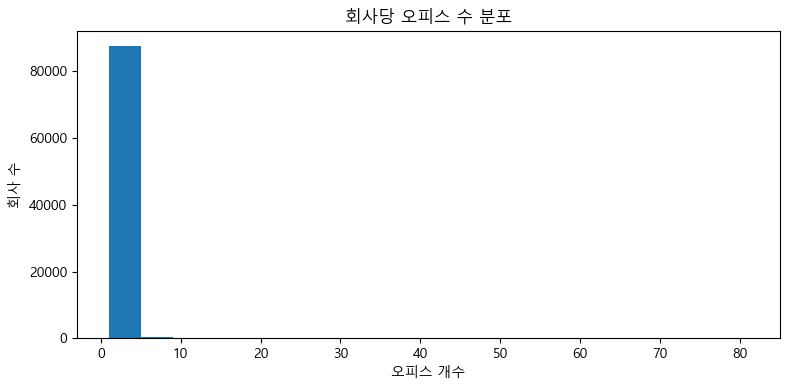

In [34]:
# 회사당 오피스 수 분포
office_per_company = (
    growth_addr
    .groupby("objects_cfpr_id")["office_id"]
    .nunique() #office_id의 고유갯수
    .rename("cnt_office")
)

# 분포 요약
display(office_per_company.describe())

# 각 오피스 개수별 회사 수
display(office_per_company.value_counts().sort_index())

plt.figure(figsize=(8,4))
plt.hist(office_per_company, bins=20)
plt.title("회사당 오피스 수 분포")
plt.xlabel("오피스 개수")
plt.ylabel("회사 수")
plt.tight_layout()
plt.show()

스타트업 사무실이 가장 많이 몰려있는 위치는?

In [35]:
growth_addr.columns

Index(['offices_c_id', 'office_id', 'description_x', 'city_x', 'state_code_x',
       'country_code_x', 'latitude', 'longitude', 'offices_description_fixed',
       'cat_offices_description', 'offices_state_filled', 'objects_cfpr_id',
       'entity_type', 'parent_c_id', 'normalized_name', 'category_code',
       'status', 'founded_at', 'closed_at', 'description_y', 'overview',
       'tag_list', 'country_code_y', 'state_code_y', 'city_y', 'region',
       'first_investment_at', 'last_investment_at', 'investment_rounds',
       'invested_companies', 'first_funding_at', 'last_funding_at',
       'funding_rounds', 'funding_total_usd', 'first_milestone_at',
       'last_milestone_at', 'milestones', 'relationships',
       'is_obj_parent_id_missing', 'is_obj_category_missing',
       'is_obj_founded_missing', 'is_obj_closed_missing',
       'is_obj_overview_missing', 'is_obj_state_missing',
       'is_obj_inv_rounds_missing', 'is_obj_inv_comp_missing',
       'cat_obj_status', 'obj_overvie

In [36]:
# 위치별 분포
display(growth_addr["country_code_x"].value_counts(dropna=False).head(5)) 
display(growth_addr["obj_state_filled"].value_counts(dropna=False).head(5))

country_code_x
USA    57697
GBR     8780
IND     4802
CAN     4162
DEU     2406
Name: count, dtype: int64

obj_state_filled
NaN    42537
CA     19184
NY      6783
MA      3315
TX      3175
Name: count, dtype: int64

TOP3 국가별 성장률 

,country_code_x,n_rounds
169,USA,20346
58,GBR,2375
31,CAN,1063
45,DEU,856
56,FRA,791
74,IND,676
80,ISR,621
52,ESP,443
34,CHN,403
11,AUS,332


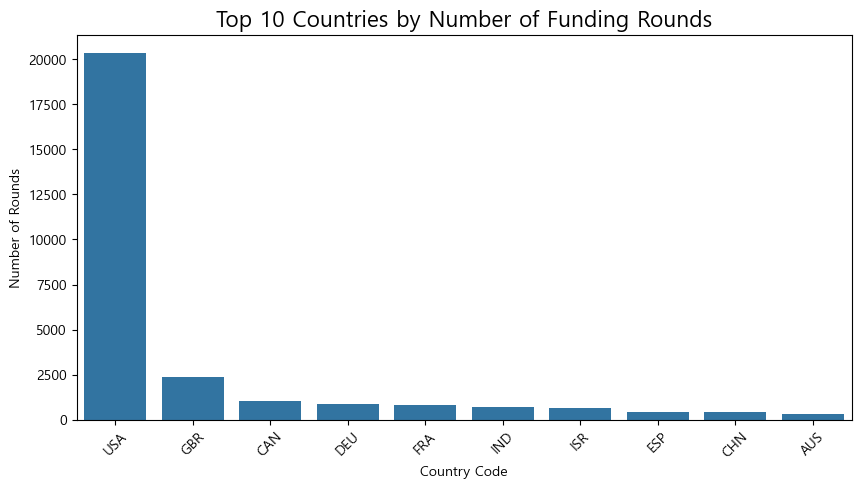

In [38]:
# 나라별 라운드 수
rounds_by_country = (
    growth_addr
    .groupby("country_code_x")["funding_round_id"]
    .nunique()
    .reset_index(name="n_rounds")
)

display(rounds_by_country.sort_values(by="n_rounds", ascending=False))

# 상위 10개 국가 - bar
top10 = rounds_by_country.nlargest(10, "n_rounds")

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top10,
    x="country_code_x",
    y="n_rounds"
)

plt.title("Top 10 Countries by Number of Funding Rounds", fontsize=16)
plt.xlabel("Country Code")
plt.ylabel("Number of Rounds")
plt.xticks(rotation=45)
plt.show()

TOP3 지역별 성장률 

,obj_state_filled,n_rounds_reg
5,CA,7329
35,NY,2041
20,MA,1535
45,TX,930
50,WA,739
40,PA,514
10,FL,513
6,CO,491
15,IL,467
47,VA,399


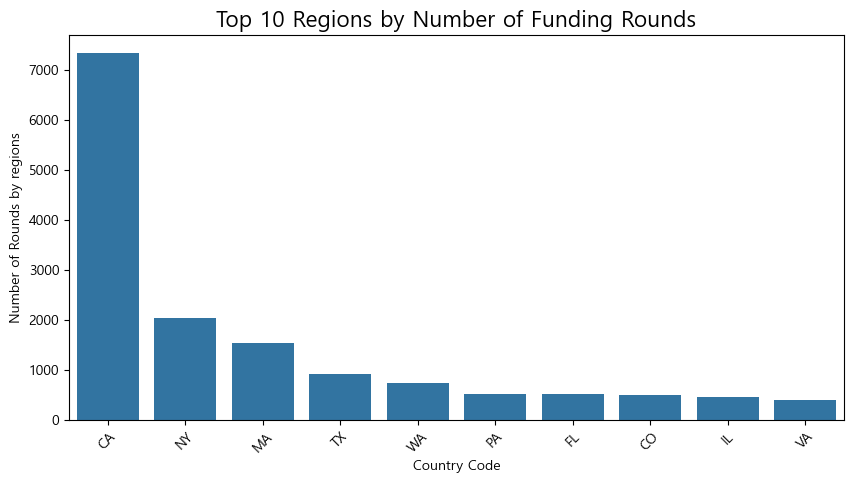

In [39]:
# 지역별 라운드 수
rounds_by_region = (
    growth_addr
    .groupby("obj_state_filled")["funding_round_id"]
    .nunique()
    .reset_index(name="n_rounds_reg")
)

display(rounds_by_region.sort_values(by="n_rounds_reg", ascending=False))

# 상위 10개 지역 - bar
top10 = rounds_by_region.nlargest(10, "n_rounds_reg")

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top10,
    x="obj_state_filled",
    y="n_rounds_reg"
)

plt.title("Top 10 Regions by Number of Funding Rounds", fontsize=16)
plt.xlabel("Country Code")
plt.ylabel("Number of Rounds by regions")
plt.xticks(rotation=45)
plt.show()

#### 성장률(이슈/마일스톤)
(mile, obj, fr)

In [40]:
print(df_growth_issues.shape) # (58605, 67)
display(df_growth_issues)

display(df_growth_issues["objects_cfpr_id"].nunique()) # 17009
display(df_growth_issues["mile_cfpr_id"].nunique()) # 17159
display(df_growth_issues["funding_round_id"].nunique()) # 11497

(58605, 67)


,Unnamed: 0,mile_cfpr_id,milestone_at,description_x,cat_mile_description,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description_y,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,...,cat_obj_overview,obj_region_fixed,cat_obj_region,obj_state_filled,obj_city_fixed,obj_category_filled,is_obj_funding_total_usd_private,is_obj_funding_rounds_private,funding_round_id,fr_c_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private
0,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,Software & Technology,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,261.0,c:12,2007-07-01,series-a,a,5000000.0,20000000.0,NaN,10.0,0.0,1.0,2007.0,2007Q3,series-a,1.0,2.397895,0.0
1,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,Software & Technology,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,2106.0,c:12,2008-05-01,series-b,b,15000000.0,NaN,NaN,6.0,0.0,0.0,2008.0,2008Q2,series-b,2.0,1.945910,0.0
2,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,Software & Technology,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,5082.0,c:12,2009-02-13,series-c+,c,35000000.0,NaN,NaN,6.0,0.0,0.0,2009.0,2009Q1,series-c+,3.0,1.945910,0.0
3,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and enterta

17009

17159

11497

In [41]:
# 스타트업 관점이므로 object_cfpr_id를 'c'로 제한
print(df_growth_issues.shape[0]) # 58605
cond = (df_growth_issues["mile_cfpr_id"].str[0] == "c")
growth_issues = df_growth_issues[cond].copy()
print(growth_issues.shape[0]) # 47856

58605
47856


한 회사당 마일스톤 평균 개수는 어느 정도일까?

,objects_cfpr_id,n_milestones
0,c:5,286
1,c:6460,260
2,c:21138,260
3,c:1628,216
4,c:12,200
...,...,...
12307,c:100634,1
12308,c:100442,1
12309,c:10022,1
12310,c:10014,1


,n_milestones
count,12312.000000
mean,3.870370
std,9.137027
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,286.000000


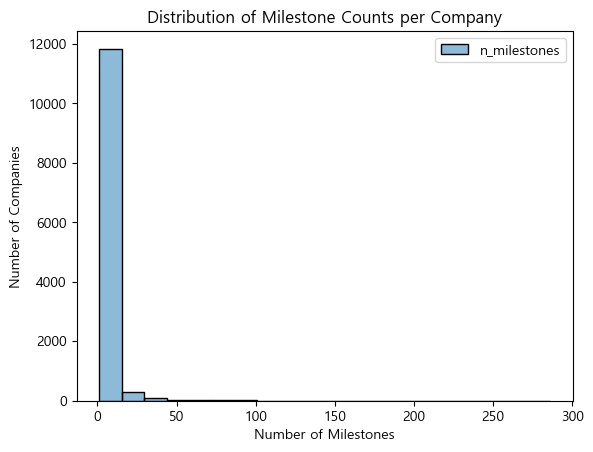

In [42]:
# 회사별 마일스톤 수
mile_counts = (
    growth_issues
    .groupby("objects_cfpr_id")["mile_cfpr_id"]
    .count()
    .sort_values(ascending=False)
    .rename("n_milestones")
    .reset_index()
)
display(mile_counts)
display(mile_counts.describe())

sns.histplot(mile_counts, bins=20)
plt.title("Distribution of Milestone Counts per Company")
plt.xlabel("Number of Milestones")
plt.ylabel("Number of Companies")
plt.show()

 마일스톤 유형에는 뭐가 있을까? (top3)

In [43]:
growth_issues["cat_mile_description"].value_counts()

cat_mile_description
launch         7556
funding        3714
award          3390
acquisition    2752
hiring         2429
               ... 
aurivo            1
aecom             1
angineer          1
unitel            1
orexigen          1
Name: count, Length: 5364, dtype: int64

마일스톤이 많은 회사가 특정 산업/라운드에 몰려있나?

In [44]:
# 마일스톤이 많은 회사 정의하기 (상위 25%)
mile_counts["n_milestones"] = mile_counts["n_milestones"].fillna(0).astype(int)

q75 = mile_counts["n_milestones"].quantile(0.75)
mile_counts["milestone_rich"] = (mile_counts["n_milestones"] >= q75)
display(mile_counts[mile_counts["milestone_rich"]].sort_values(by="n_milestones", ascending=False))

rich_true = mile_counts[mile_counts["milestone_rich"]].sort_values(by="n_milestones", ascending=False).shape[0]
issues_tot_cnt = mile_counts.shape[0]
milestone_rich_ratio = round((rich_true/issues_tot_cnt )* 100,2)
print(milestone_rich_ratio,"%")

,objects_cfpr_id,n_milestones,milestone_rich
0,c:5,286,True
1,c:6460,260,True
2,c:21138,260,True
3,c:1628,216,True
4,c:12,200,True
...,...,...,...
3070,c:18213,4,True
3069,c:159840,4,True
3103,c:54544,4,True
3102,c:139795,4,True


25.28 %


In [45]:
# n_rounds=("funding_round_id", "nunique")
growth_issues_rounds = growth_issues[growth_issues["funding_round_id"].notna()].copy()
growth_issues_company = (
    growth_issues_rounds
    .sort_values(["objects_cfpr_id", "funded_year"])  # 시간 순 정렬
    .groupby("objects_cfpr_id")
    .agg(
        category_code=("category_code", "first"),       # 첫번째 카테고리값
        n_rounds=("funding_round_id", "count"),         # funding_rounds id 갯수
        first_round_amt=("raised_amount_usd", "first"), # 첫번째 조달금액
        last_round_amt=("raised_amount_usd", "last"),   # 마지막 조달금액
        first_year=("funded_year", "first"),            # 첫번째 투자년도
        last_year=("funded_year", "last"),               # 마지막 투자년도
        first_fr_type = ("cat_fr_type", "first"),
        last_fr_type = ("cat_fr_type", "last")    # angel, 
    )
)

# 성장률(단순 비율) 마지막 조달금액/첫번째 조달금액
last_amt    = growth_issues_company["last_round_amt"]
first_amt   = growth_issues_company["first_round_amt"]
growth_issues_company["growth_ratio"] = last_amt / first_amt

# 0으로 나눈 케이스 제거
growth_issues_company = growth_issues_company[first_amt> 0]
growth_issues_company

,category_code,n_rounds,first_round_amt,last_round_amt,first_year,last_year,first_fr_type,last_fr_type,growth_ratio
objects_cfpr_id,,,,,,,,,
c:1,web,6,5250000.0,25000000.0,2005.0,2008.0,series-a,series-c+,4.761905
c:1001,web,2,5000000.0,5000000.0,2008.0,2008.0,series-a,series-a,1.000000
c:10018,analytics,3,8000000.0,15000000.0,2008.0,2013.0,series-b,series-c+,1.875000
c:10054,mobile,14,4000000.0,27500000.0,2005.0,2012.0,series-a,venture,6.875000
c:10082,analytics,5,3100000.0,3100000.0,2012.0,2012.0,series-a,series-a,1.000000
...,...,...,...,...,...,...,...,...,...
c:9939,web,2,100000.0,500000.0,2008.0,2008.0,seed,seed,5.000000
c:997,enterprise,1,14500000.0,14500000.0,2006.0,2006.0,series-c+,series-c+,1.000000
c:9972,software,5,300000.0,60000000.0,2009.0,2013.0,seed,series-c+,200.000000


In [46]:
# 라운드 단계를 묶어보자 (편향조사)
def map_stage(fr_type):
    if pd.isna(fr_type):
        return "Unknown"
    fr_type = fr_type.lower()
    if "seed" in fr_type or "angel" in fr_type:
        return "Early"
    elif "series-a" in fr_type or "series-b" in fr_type:
        return "Growth"
    elif "series-c+" in fr_type:
        return "Late"
    elif "venture" in fr_type:
        return "Venture"
    else:
        return "Other" #crowd, private, post-ipo, grant

growth_issues_company["last_stage"] = growth_issues_company["last_fr_type"].apply(map_stage)

display(growth_issues_company)

,category_code,n_rounds,first_round_amt,last_round_amt,first_year,last_year,first_fr_type,last_fr_type,growth_ratio,last_stage
objects_cfpr_id,,,,,,,,,,
c:1,web,6,5250000.0,25000000.0,2005.0,2008.0,series-a,series-c+,4.761905,Late
c:1001,web,2,5000000.0,5000000.0,2008.0,2008.0,series-a,series-a,1.000000,Growth
c:10018,analytics,3,8000000.0,15000000.0,2008.0,2013.0,series-b,series-c+,1.875000,Late
c:10054,mobile,14,4000000.0,27500000.0,2005.0,2012.0,series-a,venture,6.875000,Venture
c:10082,analytics,5,3100000.0,3100000.0,2012.0,2012.0,series-a,series-a,1.000000,Growth
...,...,...,...,...,...,...,...,...,...,...
c:9939,web,2,100000.0,500000.0,2008.0,2008.0,seed,seed,5.000000,Early
c:997,enterprise,1,14500000.0,14500000.0,2006.0,2006.0,series-c+,series-c+,1.000000,Late
c:9972,software,5,300000.0,60000000.0,2009.0,2013.0,seed,series-c+,200.000000,Late


In [47]:
growth_issues_company_all =(
        growth_issues_company
        .merge(mile_counts, left_on="objects_cfpr_id", right_on="objects_cfpr_id", how="left")
    )

display(growth_issues_company_all.head())

,objects_cfpr_id,category_code,n_rounds,first_round_amt,last_round_amt,first_year,last_year,first_fr_type,last_fr_type,growth_ratio,last_stage,n_milestones,milestone_rich
0,c:1,web,6,5250000.0,25000000.0,2005.0,2008.0,series-a,series-c+,4.761905,Late,6,True
1,c:1001,web,2,5000000.0,5000000.0,2008.0,2008.0,series-a,series-a,1.000000,Growth,2,False
2,c:10018,analytics,3,8000000.0,15000000.0,2008.0,2013.0,series-b,series-c+,1.875000,Late,3,False
3,c:10054,mobile,14,4000000.0,27500000.0,2005.0,2012.0,series-a,venture,6.875000,Venture,14,True
4,c:10082,analytics,5,3100000.0,3100000.0,2012.0,2012.0,series-a,series-a,1.000000,Growth,5,True


In [48]:
rounds_by_milestone = (
    growth_issues_company_all
    .groupby("milestone_rich")["n_rounds"]
    .agg(
        mean_rounds="mean",
        median_rounds="median",
        n_firms="count"
    )
)

display(rounds_by_milestone)

,mean_rounds,median_rounds,n_firms
milestone_rich,,,
False,1.791406,2.0,2560
True,12.803825,7.0,2039


마일스톤 전/후 raised_amount가 달라지나?

In [49]:
# 라운드 단계 분포 비교
stage_all = (
    growth_issues_company_all["last_stage"]
    .value_counts(normalize=True)
    .rename("ratio_all")
)

stage_rich = (
    growth_issues_company_all[growth_issues_company_all["milestone_rich"]]["last_stage"]
    .value_counts(normalize=True)
    .rename("ratio_milestone_rich")
)

stage_compare = pd.concat([stage_all, stage_rich], axis=1).fillna(0)
display(stage_compare)

,ratio_all,ratio_milestone_rich
last_stage,,
Growth,0.295934,0.287396
Venture,0.240922,0.259441
Early,0.230702,0.132908
Other,0.116330,0.143698
Late,0.116112,0.176557


In [50]:
# 마일스톤 전/후 raised_amount가 달라지나
growth_issues_rounds["milestone_at"] = pd.to_datetime(growth_issues_rounds["milestone_at"])
# 마일스톤이 없는 회사는 이번 분석에서 제외
growth_issues_rounds_mile = growth_issues_rounds[growth_issues_rounds["first_milestone_at"].notna()].copy()

# 마일스톤 이후 라운드 여부 플래그
growth_issues_rounds_mile["after_milestone"] = growth_issues_rounds_mile["funded_at"] >= growth_issues_rounds_mile["first_milestone_at"]

display(growth_issues_rounds_mile)

,Unnamed: 0,mile_cfpr_id,milestone_at,description_x,cat_mile_description,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,description_y,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,...,obj_region_fixed,cat_obj_region,obj_state_filled,obj_city_fixed,obj_category_filled,is_obj_funding_total_usd_private,is_obj_funding_rounds_private,funding_round_id,fr_c_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private,after_milestone
0,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,261.0,c:12,2007-07-01,series-a,a,5000000.0,20000000.0,NaN,10.0,0.0,1.0,2007.0,2007Q3,series-a,1.0,2.397895,0.0,False
1,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,2106.0,c:12,2008-05-01,series-b,b,15000000.0,NaN,NaN,6.0,0.0,0.0,2008.0,2008Q2,series-b,2.0,1.945910,0.0,False
2,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active Twitter accounts through which users can truly get the pulse of the planet.","text, messaging, social, community, twitter, tweet, twttr, microblog, sms",USA,CA,San Francisco,SF Bay,NaN,NaN,0.0,0.0,2007-07-01,...,sf bay area,sf bay area,CA,san francisco,social,0.0,0.0,5082.0,c:12,2009-02-13,series-c+,c,35000000.0,NaN,NaN,6.0,0.0,0.0,2009.0,2009Q1,series-c+,3.0,1.945910,0.0,False
3,0,c:12,2008-06-09,Survives iPhone 3G Stevenote,survives,c:12,Company,NaN,twitter,social,ipo,2006-03-21,NaN,Real time communication platform,"Created in 2006, Twitter is a global real-time communications platform with 400 million monthly visitors to twitter.com, more than 200 million monthly active users around the world.\n\nWe see a billion tweets every 2.5 days on every conceivable topic. World leaders, major athletes, star performers, news organizations and entertainment outlets are among the millions of active T

In [51]:
overall_mile = (
    growth_issues_rounds_mile
    .groupby("after_milestone")["raised_amount_usd"]
    .agg(
        count="count",
        mean="mean",
        median="median",
        std="std"
    )
)
display(overall_mile)

,count,mean,median,std
after_milestone,,,,
False,16260,1.550405e+07,4900000.0,5.115725e+07
True,12736,2.393352e+07,5000000.0,1.238743e+08
